In [125]:
import pandas as pd

def extract_data():
    df = pd.read_excel("Datensatz Piet.xlsx", sheet_name=0)

    df = df.iloc[7:, 3:-3]
    df.columns = df.iloc[0]
    cols = df.columns.tolist()
    cols[0] = "group"
    cols[1] = "features"
    df.columns = cols
    
    df.reset_index(drop=True, inplace=True)
    df = df.drop(0) 
    return df


df = extract_data()


In [126]:
df_anfang_a = df[df['group'] == 'Anfang A']
df_ende_a = df[df['group'] == 'Ende A']
df_anfang_b = df[df['group'] == 'Anfang B']
df_ende_b = df[df['group'] == 'Ende B']



In [127]:
df_anfang_a.shape, df_ende_a.shape, df_anfang_b.shape, df_ende_b.shape

((15, 22), (15, 22), (15, 22), (15, 22))

In [128]:
dfs = [df_anfang_a, df_ende_a, df_anfang_b, df_ende_b]

In [129]:
def transpose(df):
    df = df.set_index("features").T
    df['group'] = df.loc['group'].values[0]
    print(df.loc['group'].values[0])
    df.reset_index(inplace=True)
    df = df.drop(index=0).reset_index(drop=True)
    return df

In [130]:
def preprocess_data(dfs):
    dfs_T = []
    for df in dfs:
        dfs_T.append(transpose(df))
    df_all = pd.concat(dfs_T, ignore_index=True)
    df_all = df_all.set_index(["group", "index"])
    return df_all


In [131]:
df_all = preprocess_data(dfs)

Anfang A
Ende A
Anfang B
Ende B


In [132]:
def compare_by_group(df_all, group1, group2):
    anfang = df_all.xs(group1, level=0)
    ende = df_all.xs(group2, level=0)

    return (ende - anfang), anfang, ende

diff_A = compare_by_group(df_all, "Anfang A", "Ende A")

In [133]:
anfang_B = df_all.xs("Anfang B", level=0)
ende_B = df_all.xs("Ende B", level=0)

diff_B = ende_B - anfang_B

/home/dci-student/Auswertung_masterarbeit_marla/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


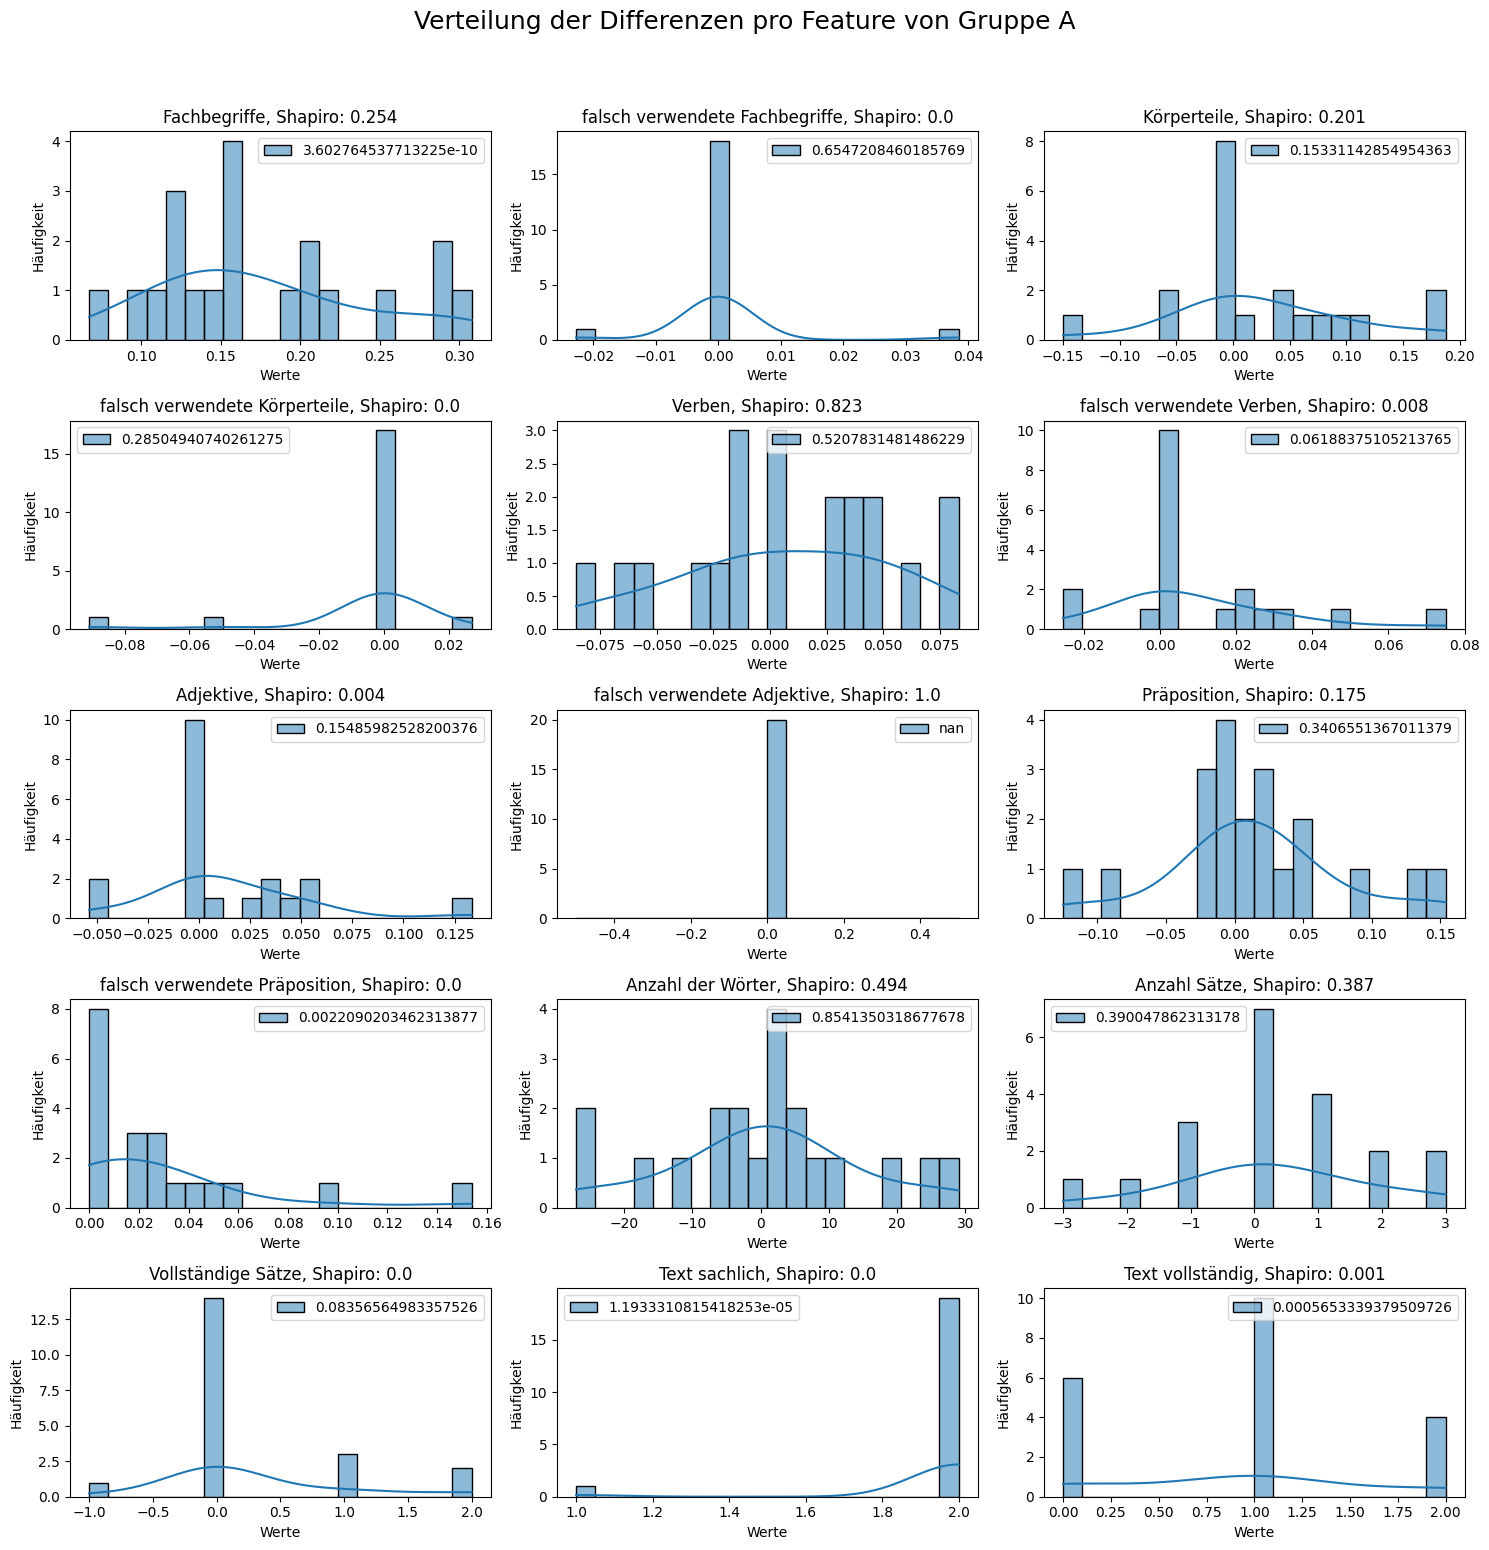

In [134]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def evaluation(*args):
    diff, anfang, ende = compare_by_group(*args)


    fig, axes = plt.subplots(5, 3, figsize=(15, 15)) 
    fig.subplots_adjust(top=0.92)  # add padding above the subtitle
    fig.suptitle(f"Verteilung der Differenzen pro Feature von Gruppe {args[1][-1]}", fontsize=18, y=1.03)
    axes = axes.flatten()
    p_values = {}
    for ax, col in zip(axes, spalten):
        werte = diff[col]  
        stat, p = stats.shapiro(werte)
        if p > 0.05:
            t_stat, p_val = stats.ttest_rel(ende[col].to_list(), anfang[col].to_list())
        else:
            w_stat, p_val = stats.wilcoxon(ende[col].to_list(), anfang[col].to_list())
        p_values[col] = p_val
        sns.histplot(werte, kde=True, bins=20, ax=ax, label=p_val)
        # sns.histplot(werte, kde=True, bins=20, ax=ax, )
        ax.set_title(f"{col}, Shapiro: {round(p, 3)}")
        ax.legend() 
        ax.set_xlabel("Werte")
        ax.set_ylabel("Häufigkeit")

    plt.tight_layout()
    plt.show()
    p_values = pd.DataFrame((p_values.items()), columns=['Feature', 'p-value'])
    return p_values

p_values = evaluation(df_all, "Anfang A", "Ende A")


In [135]:
p_values 

,Feature,p-value
0,Fachbegriffe,3.602765e-10
1,falsch verwendete Fachbegriffe,6.547208e-01
2,Körperteile,1.533114e-01
3,falsch verwendete Körperteile,2.850494e-01
4,Verben,5.207831e-01
5,falsch verwendete Verben,6.188375e-02
6,Adjektive,1.548598e-01
7,falsch verwendete Adjektive,NaN
8,Präposition,3.406551e-01
9,falsch verwendete Präposition,2.209020e-03


In [136]:
from statsmodels.stats.multitest import multipletests

def correction(p_values):
    try:
        p_values = p_values.dropna().copy()
    except AttributeError as e:
        print("NaN already removed:")

    # Bonferroni
    reject_bonf, pvals_bonf, _, _ = multipletests(list(p_values['p-value']), alpha=0.05, method="bonferroni")

    # FDR (Benjamini-Hochberg)
    reject_fdr, pvals_fdr, _, _ = multipletests(list(p_values['p-value']), alpha=0.05, method="fdr_bh")

    p_values['p_bonf'] = pvals_bonf
    p_values['p_fdr'] = pvals_fdr
    p_values['bonf_reject'] = reject_bonf
    p_values['fdr_reject'] = reject_fdr
    return p_values

p_values = correction(p_values)
p_values


,Feature,p-value,p_bonf,p_fdr,bonf_reject,fdr_reject
0,Fachbegriffe,3.602765e-10,5.043870e-09,5.043870e-09,True,True
1,falsch verwendete Fachbegriffe,6.547208e-01,1.000000e+00,7.050840e-01,False,False
2,Körperteile,1.533114e-01,1.000000e+00,2.710047e-01,False,False
3,falsch verwendete Körperteile,2.850494e-01,1.000000e+00,4.434102e-01,False,False
4,Verben,5.207831e-01,1.000000e+00,6.075803e-01,False,False
5,falsch verwendete Verben,6.188375e-02,8.663725e-01,1.732745e-01,False,False
6,Adjektive,1.548598e-01,1.000000e+00,2.710047e-01,False,False
8,Präposition,3.406551e-01,1.000000e+00,4.769172e-01,False,False
9,falsch verwendete Präposition,2.209020e-03,3.092628e-02,7.731571e-03,True,True
10,Anzahl der Wörter,8.541350e-01,1.000000e+00,8.541350e-01,False,False


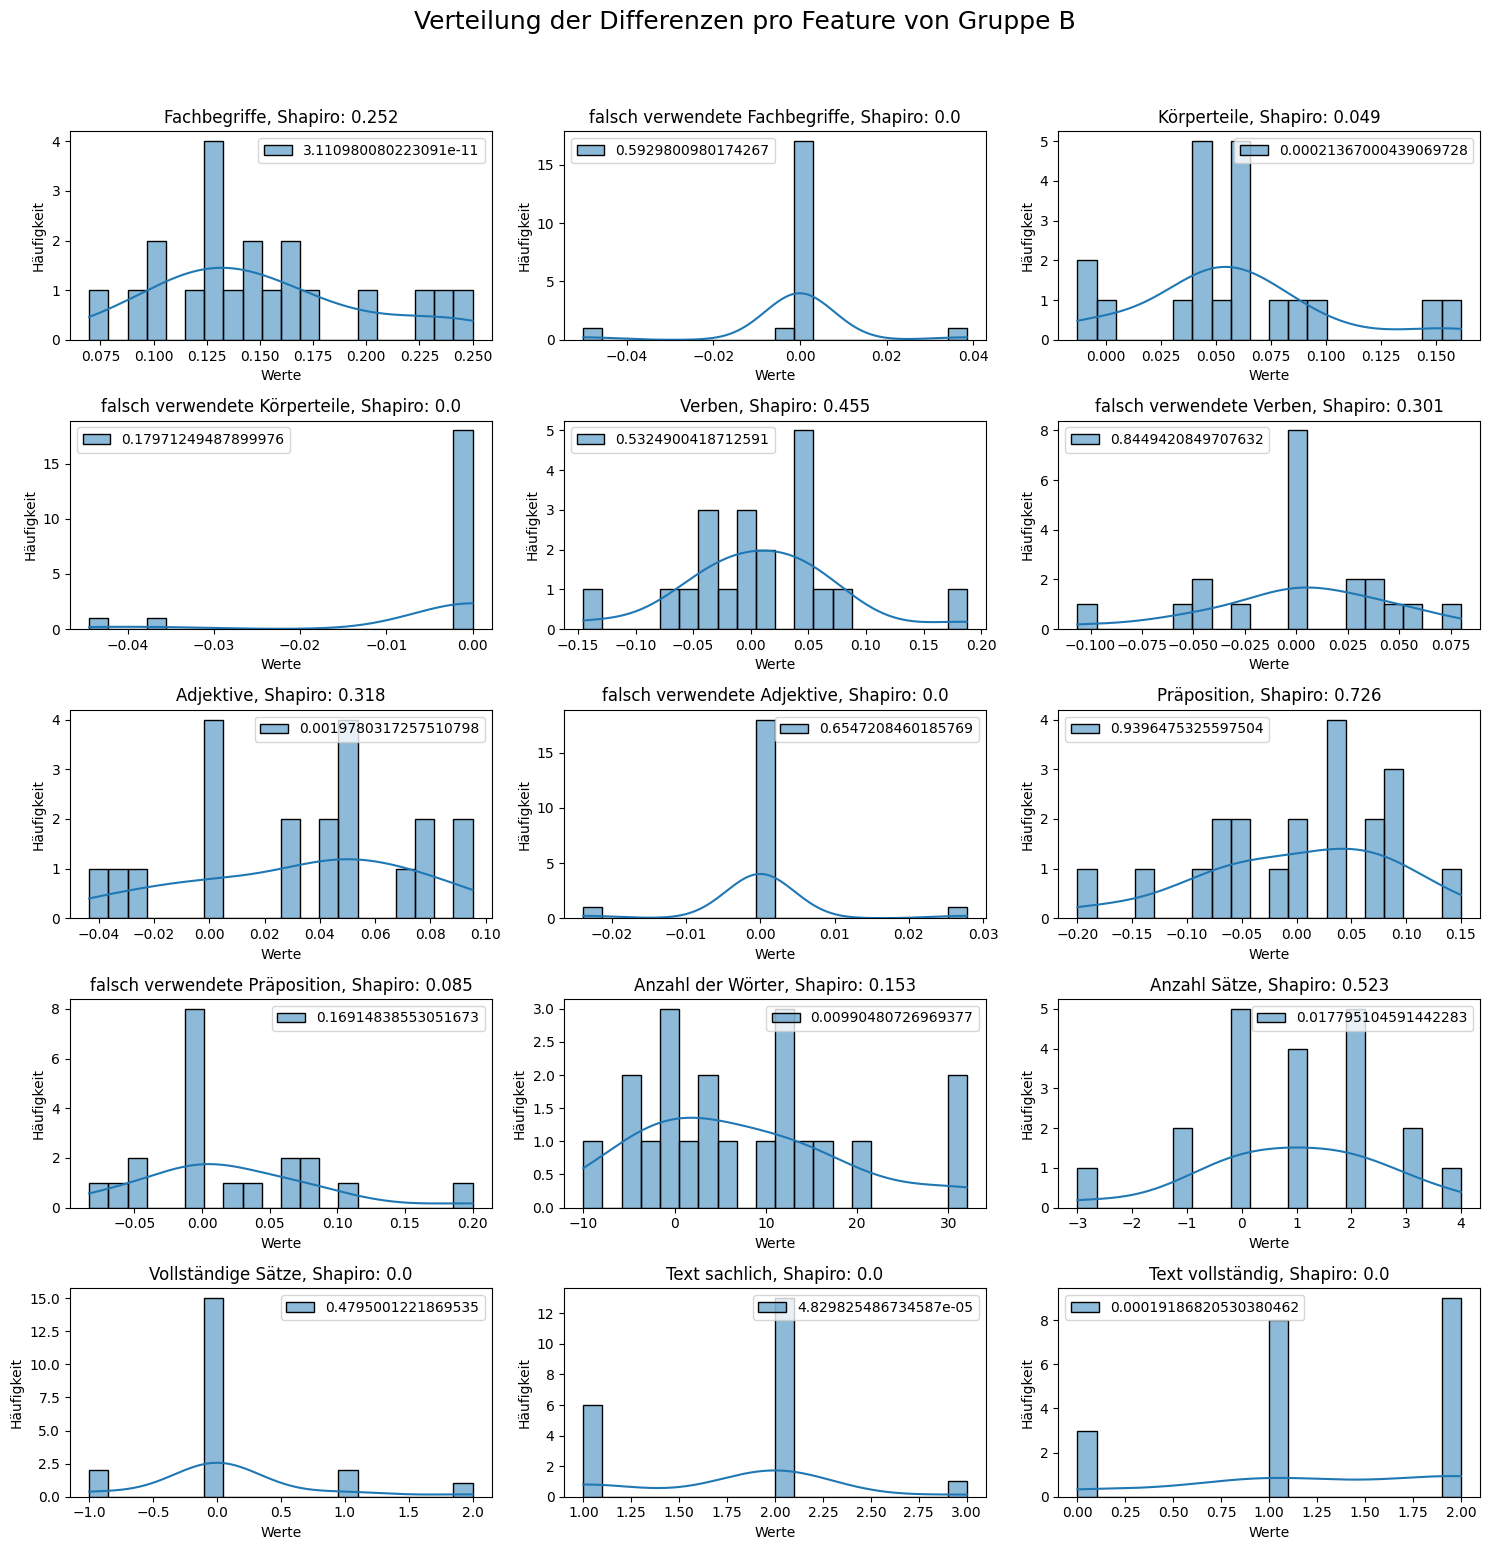

In [137]:
p_values = evaluation(df_all, "Anfang B", "Ende B")

In [138]:
p_values = correction(p_values)
p_values

,Feature,p-value,p_bonf,p_fdr,bonf_reject,fdr_reject
0,Fachbegriffe,3.110980e-11,4.666470e-10,4.666470e-10,True,True
1,falsch verwendete Fachbegriffe,5.929801e-01,1.000000e+00,7.412251e-01,False,False
2,Körperteile,2.136700e-04,3.205050e-03,8.012625e-04,True,True
3,falsch verwendete Körperteile,1.797125e-01,1.000000e+00,2.995208e-01,False,False
4,Verben,5.324900e-01,1.000000e+00,7.261228e-01,False,False
5,falsch verwendete Verben,8.449421e-01,1.000000e+00,9.052951e-01,False,False
6,Adjektive,1.978032e-03,2.967048e-02,5.934095e-03,True,True
7,falsch verwendete Adjektive,6.547208e-01,1.000000e+00,7.554471e-01,False,False
8,Präposition,9.396475e-01,1.000000e+00,9.396475e-01,False,False
9,falsch verwendete Präposition,1.691484e-01,1.000000e+00,2.995208e-01,False,False
